## Imports

In [1]:
import os
import glob
import datetime

import jax
import numpyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hssm
import arviz as az
import seaborn as sns

import sqlite3

jax.config.update('jax_platform_name', 'cpu')
hssm.set_floatX("float32")
numpyro.set_host_device_count(14)

/Users/javierrojas/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
df_raw = pd.read_stata('Data_Exp1234_clean.dta')

In [3]:
df_raw

,confidence,correct,true_shock,ab_nominal,rt,endowment,concentration,anxiety,totalmistakes,age,...,stake,stake_nominal,difficult,aligned,wishful,confusioncontrol,never_felt_deceived,bai,dpessimism,idtreatmentblock
0,0.60,1,1,20.00,4349.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,0.0,1.0,22.916664,NaN,5.0,1.190476,NaN,10.0
1,0.60,1,0,20.00,3796.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,1.0,0.0,22.916664,NaN,5.0,1.190476,NaN,10.0
2,0.65,0,0,20.00,2201.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,1.0,1.0,22.916664,NaN,5.0,1.190476,NaN,10.0
3,0.80,1,0,20.00,2945.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,0.0,0.0,22.916664,NaN,5.0,1.190476,NaN,10.0
4,0.70,0,0,20.00,3405.0,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,2.0,0.0,22.916664,NaN,5.0,1.190476,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97628,NaN,1,1,0.05,14534.5,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,0.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0
97629,NaN,1,0,0.05,15099.3,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,0.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0
97630,NaN,1,1,0.05,1715.6,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,2.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0
97631,NaN,0,1,0.05,2599.6,0.0,4.0,0.0,3.0,48.0,...,0.0,0.0,3.0,NaN,-3.260872,0.0,4.0,1.857143,6.0,101133.0


## Definitions

In [4]:
def subsitute_values_sequential(data,varname,new_values):
  unique_values = sorted(data[varname].unique())
  substitutions = {val: new_val for val, new_val in zip(unique_values,new_values)}
  return  data[varname].replace(substitutions)

In [5]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / (mad if mad>0 else np.finfo(float).eps)

In [6]:
def fit_hssm_participant(df, participant_column):
    all_summaries = []
    all_inferences = {}   # <- store InferData here

    for nsub, isub in enumerate(df[participant_column].unique()):
        print(f"___Participant {isub}, {nsub+1}/{df[participant_column].nunique()}___")

        df_sub = df[df[participant_column] == isub].drop(columns=[participant_column])

        print("Median RT =", np.median(df_sub['rt']))
        print("N trials =", len(df_sub))

        model = hssm.HSSM(
            model="ddm",
            data=df_sub,
        )

        infer_data_sub = model.sample(
            cores=3,
            chains=3,
            draws=300,
            tune=1000,
            idata_kwargs=dict(log_likelihood=True),
            progressbar=True,
            target_accept=0.99,
        )

        all_inferences[isub] = infer_data_sub

        summary_df = (
            az.summary(infer_data_sub)
              .reset_index()
              .rename(columns={'index': 'param'})
        )
        summary_df['participant_id'] = isub
        all_summaries.append(summary_df)

    all_summaries_df = pd.concat(all_summaries, ignore_index=True)
    return all_summaries_df, all_inferences

In [7]:
def write_to_sql(df, db_name, table_name):
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists="append", index=False)
    conn.close()

### Data Cleanup

In [8]:
columns_to_keep = [
    'id',              # Participant ID (for hierarchical fitting)
    'trial',           # Trial Number (for indexing/sequencing)
    'experiment',      # Filter column (must be 4)
    'rt',              # Response Time (The dependent variable distribution)
    'correct',         # Accuracy (The outcome predicted by DDM)
    'ab_nominal',      # Accuracy Bonus (Incentive condition)
    'stake_nominal',   # Loss Size (Incentive condition)
    'difficult',        # Task Difficulty (Signal quality condition)
    'endowment',      # Initial amount (Incentive con
]

In [9]:
data = df_raw.copy()
data = data[columns_to_keep]

data.rename(columns={
    'id':'participant'
}, inplace=True)

## Stim evidence: low vs high (0/1)
#data['endowment_2'] = subsitute_values_sequential(data,'stim_strength',[0.25,.5,0.75,1])

MIN_RT = 200 
MAX_RT = 35000 
MAD_THRESH_RT = 3

ACC_THRESH_LO = 0.525 
ACC_THRESH_HI = 0.975

MIN_TRIALS_PER_COND = 8
COND_VARS = ['endowment']

#count original number of trials before exclusion
n_trials_raw= len(data)

In [10]:
data = data[(~data['correct'].isna()) & (~data['rt'].isna())
             & (data['rt']> MIN_RT) & (data['rt'] < MAX_RT) & (~data['correct'].isna())]

In [11]:
data = data[data.groupby('participant')['rt'].transform(lambda x: abs(robust_z(x)))<MAD_THRESH_RT]

In [12]:
print('N trials excluded = %i / %i'%(n_trials_raw - len(data),n_trials_raw))

print('Mean RT = %i ms, median RT = %i ms, max RT = %i ms' % (data['rt'].mean(),data['rt'].median(),data['rt'].max()))

N trials excluded = 8259 / 97633
Mean RT = 2488 ms, median RT = 1525 ms, max RT = 34963 ms


## Participant Cleanup

In [13]:
participant_accuracy = data.groupby('participant')['correct'].mean()
valid_participants = participant_accuracy[(participant_accuracy > ACC_THRESH_LO) & (participant_accuracy < ACC_THRESH_HI)].index

print('N participants kept (accuracy) = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

#remove participants with extreme median RTs compared to sample
participant_rt = data.groupby('participant')['rt'].median()
valid_participants_rt = participant_rt[np.abs(robust_z(participant_rt))<3].index
print('N participants kept (RT) = %i / %i'%(len(valid_participants_rt),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants_rt)]

# remove participants, who, after exclsion, have too few trials for one or more conditions
groupby_vars = ['participant']
groupby_vars.extend(COND_VARS)
sub_trials_per_cond = data.groupby(groupby_vars).size().reset_index(name='n_trials')

#get list of participants that have at least min_trials_per_cond trials per condition (combination of incentive and desirability values)
df_participants_with_min_trials = sub_trials_per_cond.groupby('participant').filter(lambda x: (x['n_trials'] >= MIN_TRIALS_PER_COND).all())
valid_participants = df_participants_with_min_trials['participant'].unique().tolist()
print('N participants kept after excluding participants with too few trials = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

N participants kept (accuracy) = 1059 / 1114
N participants kept (RT) = 971 / 1059
N participants kept after excluding participants with too few trials = 912 / 971


## HSSM DataFrame

In [14]:
data

,participant,trial,experiment,rt,correct,ab_nominal,stake_nominal,difficult,endowment
11520,61.0,1.0,2.0,2476.735,0,0.1,0.0,1.0,0.0
11521,61.0,2.0,2.0,2310.175,1,0.1,0.0,0.0,0.0
11523,61.0,4.0,2.0,2004.485,1,0.1,0.0,0.0,0.0
11524,61.0,5.0,2.0,2202.085,1,0.1,0.0,1.0,0.0
11526,61.0,7.0,2.0,2188.020,1,0.1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
97552,1113.0,79.0,4.0,1329.400,1,10.0,1.0,0.0,5.0
97553,1113.0,80.0,4.0,1506.900,1,10.0,1.0,1.0,5.0
97554,1113.0,81.0,4.0,1345.200,1,10.0,1.0,0.0,5.0
97555,1113.0,82.0,4.0,2321.000,0,10.0,1.0,3.0,5.0


In [15]:
df_hssm = pd.DataFrame({
    'response': data['correct'].astype('int32'),
    'rt': (data['rt'] / 1000).astype('float32'),
    'participant_id': data['participant'].astype('int32')
})

df_hssm = df_hssm.astype({col: 'float32' for col in df_hssm.select_dtypes(include='float64').columns})

In [16]:
df_hssm

,response,rt,participant_id
11520,0,2.476735,61
11521,1,2.310175,61
11523,1,2.004485,61
11524,1,2.202085,61
11526,1,2.188020,61
...,...,...,...
97552,1,1.329400,1113
97553,1,1.506900,1113
97554,1,1.345200,1113
97555,0,2.321000,1113


# Test dataset

In [59]:
random_ids = np.random.choice(
    df_hssm.participant_id.unique(),
    size=round(len(df_hssm.participant_id.unique())/50),
    replace = False
)

In [60]:
df_test = df_hssm[df_hssm['participant_id'].isin(random_ids)]

In [61]:
df_hssm.participant_id.nunique(), df_test.participant_id.nunique()

(912, 18)

In [62]:
df_test

,response,rt,participant_id
13897,0,1.2690,89
13898,0,1.1590,89
13899,0,1.1010,89
13900,1,1.8690,89
13901,1,0.6890,89
...,...,...,...
91203,0,2.7979,1039
91204,0,5.4584,1039
91205,1,1.9089,1039
91207,1,2.0171,1039


In [63]:
len(df_raw.id.unique())

1114

In [64]:
len(df_test.participant_id.unique())

18

# Partial dataset for fitting

In [65]:
part_df = df_test.copy()

In [66]:
fitted_participantd_ids = pd.read_sql_query("SELECT DISTINCT participant_id FROM summaries", sqlite3.connect('hssm_fits.db'))

In [67]:
fitted_participantd_ids

,participant_id
0,80
1,141
2,171
3,205
4,389
5,398
6,440
7,443
8,459
9,475


In [68]:
df_test

,response,rt,participant_id
13897,0,1.2690,89
13898,0,1.1590,89
13899,0,1.1010,89
13900,1,1.8690,89
13901,1,0.6890,89
...,...,...,...
91203,0,2.7979,1039
91204,0,5.4584,1039
91205,1,1.9089,1039
91207,1,2.0171,1039


In [69]:
part_df = df_test[~df_test['participant_id'].isin(fitted_participantd_ids.participant_id.values)]

In [70]:
part_df

,response,rt,participant_id
13897,0,1.2690,89
13898,0,1.1590,89
13899,0,1.1010,89
13900,1,1.8690,89
13901,1,0.6890,89
...,...,...,...
91203,0,2.7979,1039
91204,0,5.4584,1039
91205,1,1.9089,1039
91207,1,2.0171,1039


## Fit model

In [71]:
df_fit_output, az_data = fit_hssm_participant(part_df, 'participant_id')

___Participant 89, 1/18___
Median RT = 1.165
N trials = 76


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 161, 2/18___
Median RT = 1.760575
N trials = 81


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 207, 3/18___
Median RT = 1.6753525
N trials = 74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 217, 4/18___
Median RT = 1.063
N trials = 87


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 386, 5/18___
Median RT = 0.92175
N trials = 44


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 68 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 509, 6/18___
Median RT = 1.0364001
N trials = 74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 109 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 551, 7/18___
Median RT = 0.61345
N trials = 62


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 626, 8/18___
Median RT = 1.4487
N trials = 58


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 633, 9/18___
Median RT = 0.7846
N trials = 83


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 634, 10/18___
Median RT = 0.9292
N trials = 86


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 642, 11/18___
Median RT = 1.7343
N trials = 83


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 683, 12/18___
Median RT = 1.0776501
N trials = 80


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 832, 13/18___
Median RT = 1.97525
N trials = 64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 867, 14/18___
Median RT = 3.2678
N trials = 77


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Only 300 samples in chain.


___Participant 871, 15/18___
Median RT = 2.1328
N trials = 88


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 957, 16/18___
Median RT = 3.07235
N trials = 92


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1036, 17/18___
Median RT = 2.7225
N trials = 89


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


___Participant 1039, 18/18___
Median RT = 2.5619
N trials = 87


Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [t, a, z, v]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [72]:
df_fit_output

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,-0.086,0.187,-0.412,0.268,0.012,0.008,258.0,341.0,1.02,89
1,t,0.592,0.028,0.536,0.644,0.002,0.001,330.0,191.0,1.02,89
2,a,0.893,0.051,0.795,0.986,0.003,0.002,409.0,505.0,1.01,89
3,z,0.617,0.048,0.541,0.729,0.003,0.002,261.0,149.0,1.02,89
4,v,0.232,0.115,0.006,0.444,0.006,0.004,420.0,478.0,1.02,161
...,...,...,...,...,...,...,...,...,...,...,...
67,z,0.509,0.056,0.413,0.618,0.003,0.002,372.0,312.0,1.01,1036
68,v,0.218,0.116,0.016,0.452,0.006,0.004,393.0,440.0,1.01,1039
69,t,1.088,0.072,0.928,1.197,0.004,0.003,355.0,288.0,1.00,1039
70,a,1.397,0.080,1.251,1.544,0.004,0.003,504.0,553.0,1.00,1039


# store data

In [73]:
write_to_sql(df_fit_output, 'hssm_fits.db', 'summaries')

# az plot

array([<Axes: title={'center': 'v'}>, <Axes: title={'center': 't'}>,
       <Axes: title={'center': 'a'}>, <Axes: title={'center': 'z'}>],
      dtype=object)

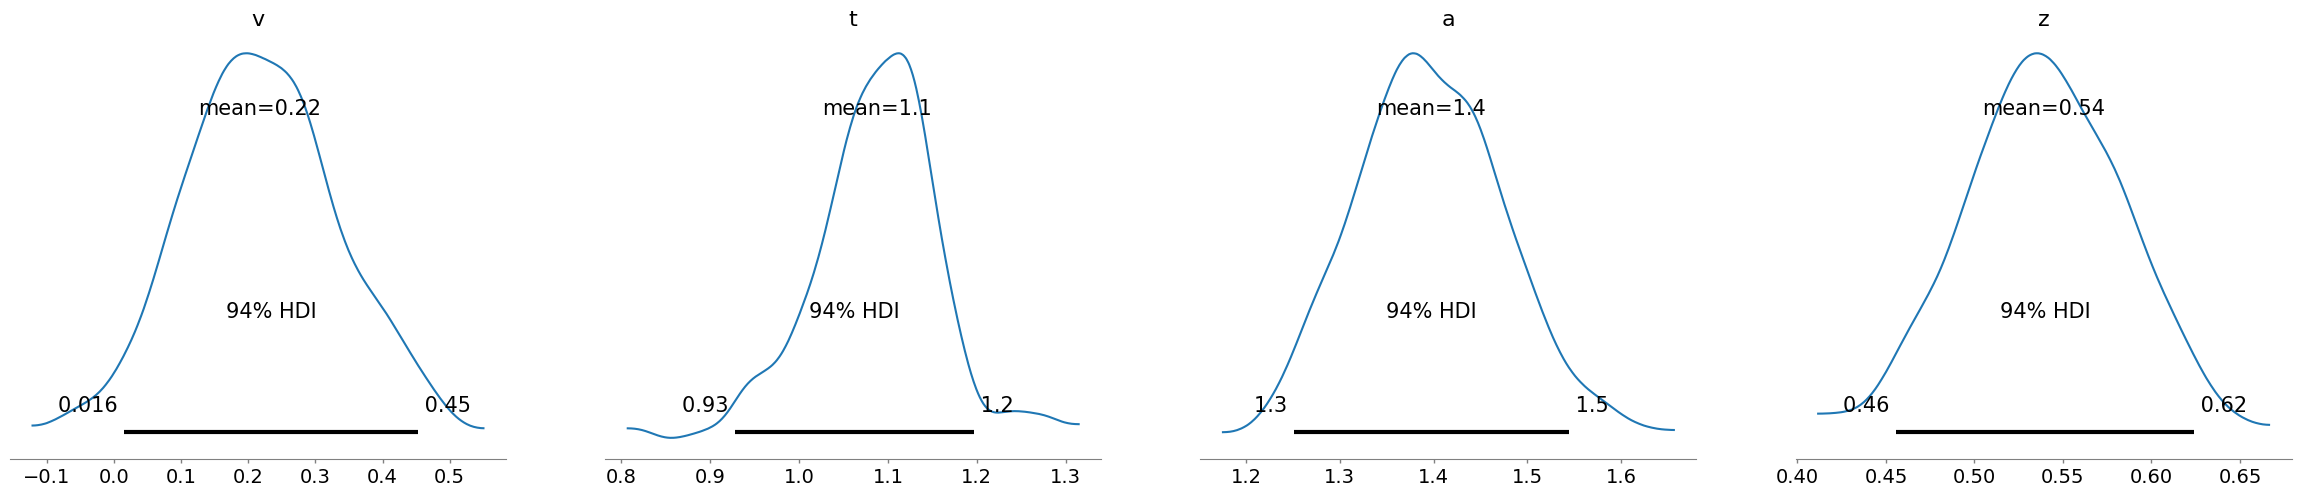

In [75]:
az.plot_posterior(az_data[1039])

# Drift rate plots

In [76]:
df_v = df_fit_output[df_fit_output['param']=='v']

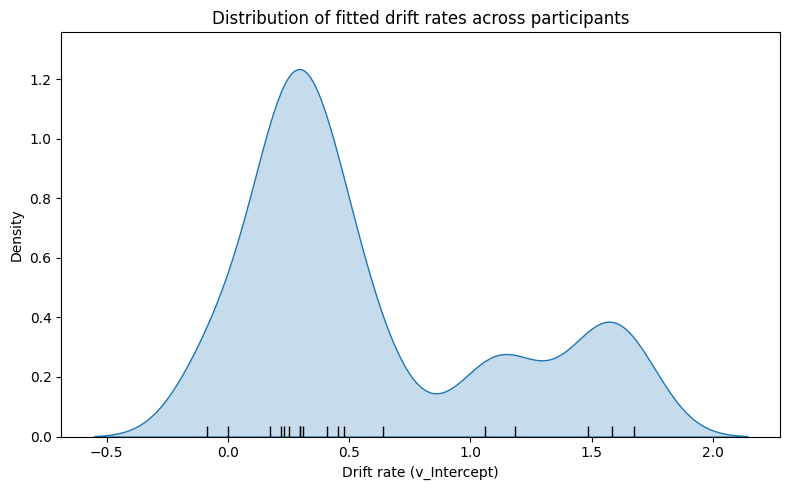

In [77]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_v['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v['mean'], color='k')
plt.xlabel("Drift rate (v_Intercept)")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()

# Read SQL

In [78]:
query = "SELECT * FROM summaries WHERE param='v'"
conn = sqlite3.connect('hssm_fits.db')
df_v_all = pd.read_sql_query(query, conn)
conn.close()

In [79]:
df_v_all

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,2.781,0.537,1.769,3.746,0.053,0.039,102.0,199.0,1.02,80
1,v,0.653,0.160,0.355,0.957,0.008,0.006,364.0,431.0,1.01,141
2,v,1.736,0.423,1.058,2.550,0.042,0.030,104.0,224.0,1.03,171
3,v,0.173,0.159,-0.148,0.464,0.008,0.005,437.0,507.0,1.01,205
4,v,0.813,0.258,0.334,1.339,0.018,0.013,214.0,195.0,1.01,389
5,v,0.750,0.188,0.413,1.100,0.010,0.007,374.0,491.0,1.01,398
6,v,1.083,0.257,0.597,1.549,0.015,0.011,283.0,448.0,1.00,440
7,v,0.310,0.140,0.072,0.576,0.007,0.005,421.0,439.0,1.01,443
8,v,2.120,0.366,1.493,2.847,0.018,0.013,401.0,350.0,1.01,459
9,v,1.444,0.269,0.958,1.987,0.017,0.012,262.0,400.0,1.02,475
